# Summary

This code gives a short summary on the current progress (last update: 17.04.2020).
In the following a different NN are trained to learn the mapping HNG-Parameters (a,b,g*,w,h0) to HNG-Volatility surface as well as the inverse mapping
The used dataset are generated by the DatasetGenearotor.m. The interest rates used are interpolated from T-bill rates.
The grid used for pricing is  [30, 60, 90, 120, 150, 180, 210] days for Maturities and inv. Moneyness (K/S)    [0.9, 0.925, 0.95, 0.975, 1.0, 1.025, 1.05, 1.075, 1.1].

A good num of epoch is 350-(Ntotal/1000)

# 1. Preambel and Data Import
This Initialisation will be used for everyfile to ensure the same conditions everytime! For more details check the configuration file config_latent.py

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.compat.v1.keras.models import Sequential,Model
from tensorflow.compat.v1.keras.layers import Reshape,InputLayer,Dense,Flatten, Conv2D,Conv1D, Dropout, Input,ZeroPadding2D,ZeroPadding1D,MaxPooling2D
from tensorflow.compat.v1.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.optimize import minimize,NonlinearConstraint
#import matplotlib.lines as mlines
#import matplotlib.transforms as mtransforms
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import scipy
import scipy.io
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import random
#import time
#import keras

## import data set
from config_latent import Nparameters,maturities,strikes,Nstrikes,Nmaturities,Ntest,Ntrain,Nval
from config_latent import xx,rates_train,rates_val,rates_test,ub,lb,diff,bound_sum
from config_latent import X_train,X_test,X_val,X_train_trafo,X_val_trafo,X_test_trafo,X_train_trafo2,X_val_trafo2,X_test_trafo2
# vola
from config_latent import yy,y_train,y_test,y_val,ub_vola,lb_vola,diff_vola,bound_sum_vola
from config_latent import y_train_trafo,y_val_trafo,y_test_trafo
from config_latent import y_train_trafo1,y_val_trafo1,y_test_trafo1
from config_latent import y_train_trafo2,y_val_trafo2,y_test_trafo2
# price
from config_latent import yy_price,y_train_price,y_test_price,y_val_price,ub_price,lb_price,diff_price,bound_sum_price
from config_latent import y_train_trafo_price,y_val_trafo_price,y_test_trafo_price
from config_latent import y_train_trafo1_price,y_val_trafo1_price,y_test_trafo1_price
from config_latent import y_train_trafo2_price,y_val_trafo2_price,y_test_trafo2_price

# import custom functions #scaling tools
from config_latent import ytransform, yinversetransform,myscale,myinverse

#custom errors
from add_func_latent import root_mean_squared_error,root_relative_mean_squared_error,mse_constraint,rmse_constraint
#else
from add_func_latent import constraint_violation,pricing_plotter,calibration_plotter_deterministic,plotter_autoencoder

tf.compat.v1.keras.backend.set_floatx('float64')  

from add_func_latent import ownTimer
t = ownTimer()

def autoencoder(nn1,nn2):
    def autoencoder_predict(y_values):
        prediction = nn2.predict(y_values)
        prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
        forecast = nn1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
        return forecast
    return autoencoder_predict

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16009234682175514207
]


# 2.1 CNN as Encoder / Vola Kernel with no riskfree rate input

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 8, 5, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 5, 32)          128       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 6, 32)          4128      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 5, 7, 32)          0         
____

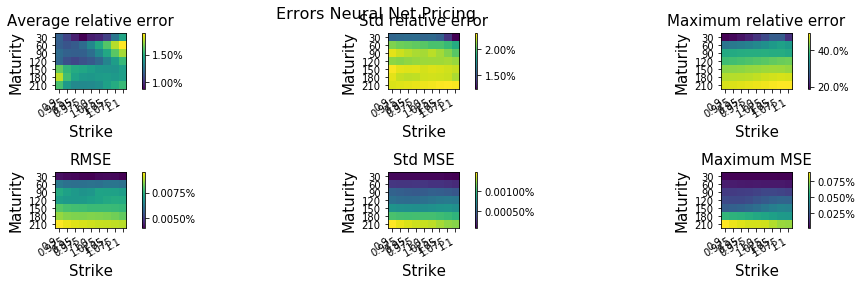

In [3]:
NN1 = Sequential() 
NN1.add(InputLayer(input_shape=(Nparameters,1,1,)))
NN1.add(ZeroPadding2D(padding=(2, 2)))
NN1.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
NN1.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1.summary()
#setting
#NN1.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
#NN1.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#NN1.fit(X_train_trafo, y_train_trafo1, batch_size=64, validation_data = (X_val_trafo, y_val_trafo1), epochs = 80, verbose = True, shuffle=1)
#NN1.save_weights("pricerweights_noriskfreerate_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN1.load_weights("pricerweights_noriskfreerate_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
#  Results 
# The following plots show the performance on the testing set
S0=1.
y_test_re    = yinversetransform(y_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1.predict(X_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
#plots
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)

# 2.2 CNN as Encoder / Vola Kernel with riskfree rate]

In [ ]:
NN1a = Sequential() 
NN1a.add(InputLayer(input_shape=(Nparameters+Nmaturities,1,1,)))
NN1a.add(ZeroPadding2D(padding=(0, 2)))
NN1a.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
NN1a.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1a.summary()

#setting
NN1a.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#NN1.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
inputs_train =np.concatenate((X_train_trafo,rates_train.reshape((Ntrain,Nmaturities,1,1))),axis=1)
inputs_val = np.concatenate((X_val_trafo,rates_val.reshape((Nval,Nmaturities,1,1))),axis=1)
inputs_test = np.concatenate((X_test_trafo,rates_test.reshape((Ntest,Nmaturities,1,1))),axis=1)
NN1a.fit(inputs_train, y_train_trafo1, batch_size=64, validation_data = (inputs_val, y_val_trafo1), epochs = 80, verbose = True, shuffle=1)
NN1a.save_weights("pricerweights_riskfreerate_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN1a.load_weights("pricerweights_riskfreerate_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean

#  Results 
# The following plots show the performance on the testing set
S0=1.
y_test_re    = yinversetransform(y_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1a.predict(inputs_test).reshape((Ntest,Nmaturities,Nstrikes))
#plots
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 12, 5, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 5, 32)         128       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 12, 7, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 6, 32)         4128      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 5, 32)          9

# 2.3 CNN as Encoder / Pricing Kernel with riskfree rate

In [ ]:
NN1b = Sequential() 
NN1b.add(InputLayer(input_shape=(Nparameters+Nmaturities,1,1,)))
NN1b.add(ZeroPadding2D(padding=(0, 2)))
NN1b.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =False,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
NN1b.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =False,strides =(2,1),activation ='tanh', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1b.summary()

#setting
#NN1b.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
NN1b.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
inputs_train =np.concatenate((X_train_trafo,rates_train.reshape((Ntrain,Nmaturities,1,1))),axis=1)
inputs_val = np.concatenate((X_val_trafo,rates_val.reshape((Nval,Nmaturities,1,1))),axis=1)
inputs_test = np.concatenate((X_test_trafo,rates_test.reshape((Ntest,Nmaturities,1,1))),axis=1)
#NN1b.fit(inputs_train, y_train_trafo1, batch_size=64, validation_data = (inputs_val, y_val_trafo1_price),epochs = 80, verbose = True, shuffle=1)
#NN1b.save_weights("pricerweights_riskfreerate_price_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN1b.load_weights("pricerweights_riskfreerate_price_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean


#  Results 
# The following plots show the performance on the testing set
S0=1.
y_test_re    = yinversetransform(y_test_trafo_price,0).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1b.predict(inputs_test).reshape((Ntest,Nmaturities,Nstrikes))
#plots
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)

# 2.4 CNN as Encoder / Pricing Kernel with no riskfree rate]:

In [ ]:
NN1c = Sequential() 

#NN1c.add(InputLayer(input_shape=(Nparameters,1,1,)))
#N1c.add(ZeroPadding2D(padding=(2, 2)))
#NN1c.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1c.add(Dropout(0.25))

NN1c.add(ZeroPadding2D(padding=(1,1)))
#NN1c.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
#NN1c.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1c.add(ZeroPadding2D(padding=(1,1)))
#NN1c.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1c.add(ZeroPadding2D(padding=(1,1)))
NN1c.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1c.add(ZeroPadding2D(padding=(1,1)))
NN1c.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1c.add(MaxPooling2D(pool_size=(2, 1)))
NN1c.add(Dropout(0.25))
#NN1c.add(ZeroPadding2D(padding=(0,1)))
NN1c.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='tanh', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1c.add(MaxPooling2D(pool_size=(4, 1)))
NN1c.summary()
#setting
#NN1c.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
NN1c.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
tmp_train = np.argsort(np.min(y_train_price,axis=1))
tmp_test = np.argsort(np.min(y_test_price,axis=1))
tmp_val = np.argsort(np.min(y_val_price,axis=1))
y_train_tmp = y_train_trafo1_price[tmp_train[4000:],:,:,:]
y_val_tmp = y_val_trafo1_price[tmp_val[1500:],:,:,:]
y_test_tmp =  y_test_trafo1_price[tmp_test[1500:],:,:,:]
X_train_tmp = X_train_trafo[tmp_train[4000:],:,:,:]
X_val_tmp = X_val_trafo[tmp_val[1500:],:,:,:]
X_test_tmp = X_test_trafo[tmp_test[1500:],:,:,:]
#NN1c.fit(X_train_tmp, y_train_tmp, batch_size=64, validation_data = (X_val_tmp, y_val_tmp), epochs = 300, verbose = True, shuffle=1)
NN1c.fit(X_train_trafo, y_train_trafo1, batch_size=64, validation_data = (X_val_trafo, y_val_trafo1_price), epochs = 300, verbose = True, shuffle=1)
NN1c.save_weights("pricerweights_noriskfreerate_price.h5")
#NN1c.load_weights("pricerweights_noriskfreerate_price.h5")

#  Results 
# The following plots show the performance on the testing set
S0=1.
#y_test_re    = yinversetransform(y_test_tmp,0).reshape((Ntest-1500,Nmaturities,Nstrikes))
#prediction   = NN1c.predict(X_test_tmp).reshape((Ntest-1500,Nmaturities,Nstrikes))

y_test_re    = yinversetransform(y_test_trafo_price).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1c.predict(X_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
#plots
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)
err_matrix = np.mean(err_rel_mat,axis=(1,2))
err_idx = np.argsort(err_matrix)
plt.figure(figsize= (14,4))
plt.plot(np.min(y_test_re,axis=(1,2)))
#plt.plot(err_matrix)
plt.show()

# 2.4 CNN as Encoder / Vola and Pricing Kernelsimultaniously with no riskfree rate]:

In [12]:
#tf.config.experimental_run_functions_eagerly(False)
y_train_comb = np.concatenate((y_train_trafo2,y_train_trafo2_price),axis = 3)
y_test_comb = np.concatenate((y_test_trafo2,y_test_trafo2_price),axis = 3)
y_val_comb = np.concatenate((y_val_trafo2,y_val_trafo2_price),axis = 3)

y_train_comb1 = np.concatenate((y_train_trafo1,y_train_trafo1_price),axis = 1)
y_test_comb1 = np.concatenate((y_test_trafo1,y_test_trafo1_price),axis = 1)
y_val_comb1 = np.concatenate((y_val_trafo1,y_val_trafo1_price),axis = 1)
NN1comb = Sequential() 
NN1comb.add(InputLayer(input_shape=(Nparameters,)))
NN1comb.add(Dense(10,activation = "elu",use_bias=True))
NN1comb.add(Dense(30,activation = "elu",use_bias=True))
NN1comb.add(Dense(60,activation = "elu",use_bias=True))
NN1comb.add(Dense(120,activation = "elu",use_bias=True))
NN1comb.add(Reshape((15, 2,4), input_shape=(120,)))
NN1comb.add(ZeroPadding2D(padding=(2, 2)))
NN1comb.add(Conv2D(8, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1comb.add(ZeroPadding2D(padding=(2, 2)))
NN1comb.add(Conv2D(30, (3, 3), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1comb.add(Conv2D(30, (3, 3), padding='valid',use_bias =True,strides =(2,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(10, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1comb.add(Conv2D(9, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(9, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(9, (3, 3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(9, (2, 3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(9, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
#NN1comb.add(Conv2D(Nstrikes, (1, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1comb.summary()
#setting
NN1comb.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
#NN1comb.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#NN1comb.fit(X_train_trafo, y_train_trafo1, batch_size=64, validation_data = (X_val_trafo, y_val_trafo1), epochs = 300, verbose = True, shuffle=1)
NN1comb.fit(X_train_trafo.reshape((Ntrain,Nparameters)), y_train_comb1, batch_size=64, validation_data = (X_val_trafo.reshape((Nval,Nparameters)), y_val_comb1), epochs = 100, verbose = True, shuffle=1)
NN1comb.save_weights("pricerweights_comb231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN1comb.load_weights("pricerweights_comb231046.h5")#id_3283354135d44b67_data_price_norm_231046clean


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_33 (Dense)             (None, 30)                330       
_________________________________________________________________
dense_34 (Dense)             (None, 60)                1860      
_________________________________________________________________
dense_35 (Dense)             (None, 120)               7320      
_________________________________________________________________
reshape_8 (Reshape)          (None, 15, 2, 4)          0         
_________________________________________________________________
zero_padding2d_56 (ZeroPaddi (None, 19, 6, 4)          0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 17, 6, 8)         

15266/15266 [==============================] - 9s 621us/sample - loss: 4.4538e-04 - MAPE: 20.5345 - val_loss: 3.6763e-04 - val_MAPE: 20.8265
Epoch 35/100
15266/15266 [==============================] - 9s 588us/sample - loss: 4.3679e-04 - MAPE: 19.2341 - val_loss: 4.0023e-04 - val_MAPE: 21.0715
Epoch 36/100
15266/15266 [==============================] - 9s 565us/sample - loss: 4.7636e-04 - MAPE: 25.3302 - val_loss: 3.5358e-04 - val_MAPE: 22.6780
Epoch 37/100
15266/15266 [==============================] - 9s 567us/sample - loss: 4.5738e-04 - MAPE: 20.8070 - val_loss: 4.6856e-04 - val_MAPE: 19.3464
Epoch 38/100
15266/15266 [==============================] - 9s 561us/sample - loss: 4.4367e-04 - MAPE: 21.3442 - val_loss: 3.9406e-04 - val_MAPE: 25.1485
Epoch 39/100
15266/15266 [==============================] - 9s 576us/sample - loss: 4.6779e-04 - MAPE: 20.8181 - val_loss: 4.2503e-04 - val_MAPE: 19.8583
Epoch 40/100
15266/15266 [==============================] - 9s 566us/sample - loss: 3.750

KeyboardInterrupt: 

# 3. CNN as  Decoder/Inverse Mapping / Calibration

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 5, 7, 64)          640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 6, 64)          16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 3, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 2, 64)          16448     
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 3, 4, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 3, 64)          16448     
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 4, 5, 64)         

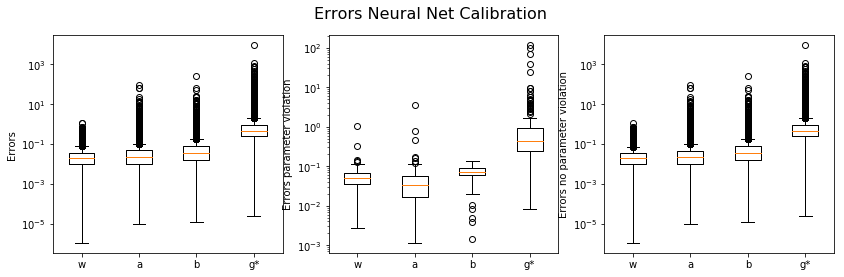

violation error mean in %: [  5.98927776   6.8221351    7.42543897 316.35085763]
no violation error mean in %: [  2.9924243   12.13138926  18.85546468 450.31256967]
violation error median in %: [ 5.03271975  3.38136608  7.19288749 44.51284495]
no violation error median in %: [ 1.97899821  2.12653456  3.39140995 42.10112391]
error mean in %: [  3.05715633  12.01670937  18.60857613 447.41899669]
error median in %: [ 2.01685614  2.1496453   3.51265672 42.12497992]


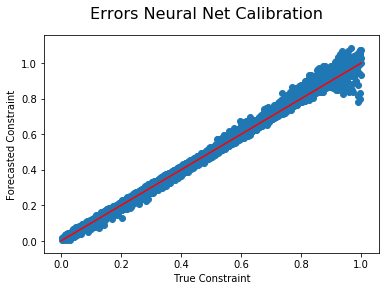

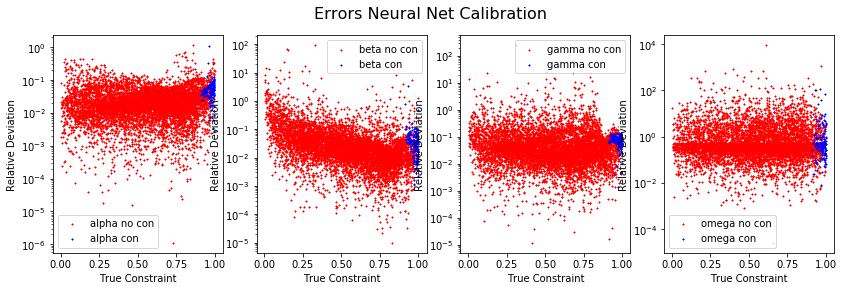

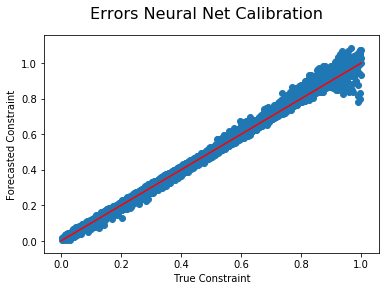

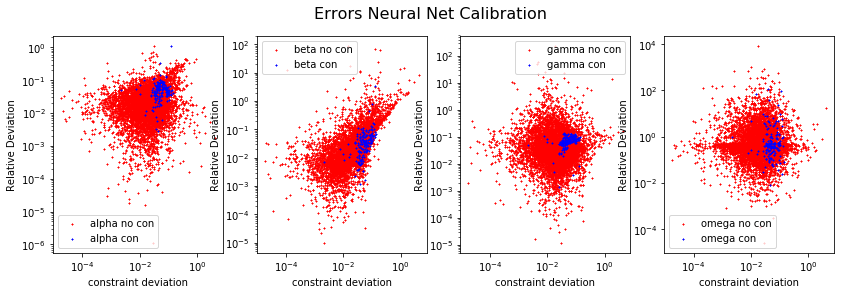

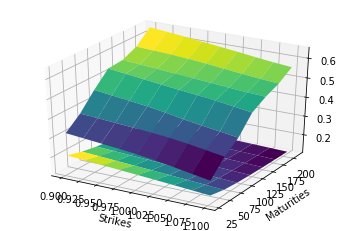

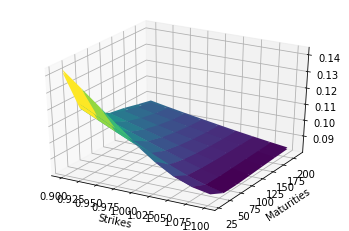

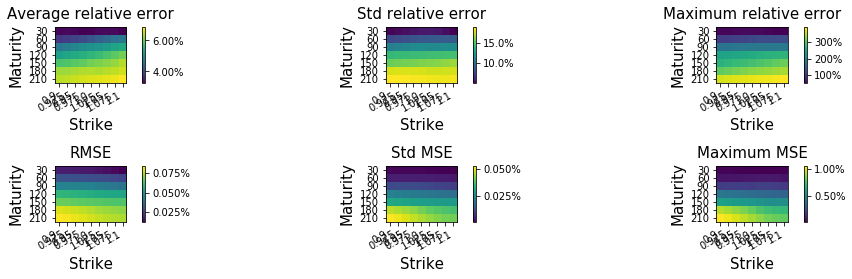

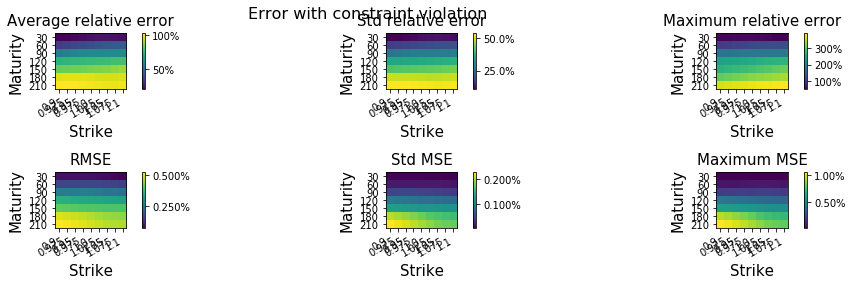

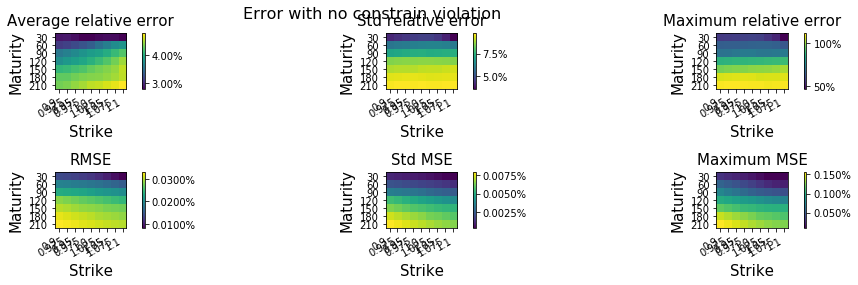

In [4]:
NN2 = Sequential() 
NN2.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2.add(Conv2D(64,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(MaxPooling2D(pool_size=(2, 2)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Flatten())
NN2.add(Dense(Nparameters,activation = 'linear',use_bias=True))
NN2.summary()
#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])

#setting
#NN2.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#history = NN2.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
#    epochs=300, verbose = True, shuffle=1)
#NN2.save_weights("calibrationweights_noh0.h5")
NN2.load_weights("calibrationweights_noh0.h5")


# ### 3.1 Results

from add_func_noh0 import calibration_plotter
prediction_calibration = NN2.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])

#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)


# ### 3.2 Testing the performace of the AutoEncoder/Decoder Combination
# We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.

forecast = autoencoder(NN1,NN2)(y_test_trafo2)
#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)



# 4 CNN as  Decoder/Inverse Mapping / Calibration TANHELU


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 5, 7, 12)          120       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 6, 24)          1176      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 3, 24)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 2, 32)          3104      
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 3, 4, 32)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 2, 3, 32)          4128      
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 4, 5, 32)         

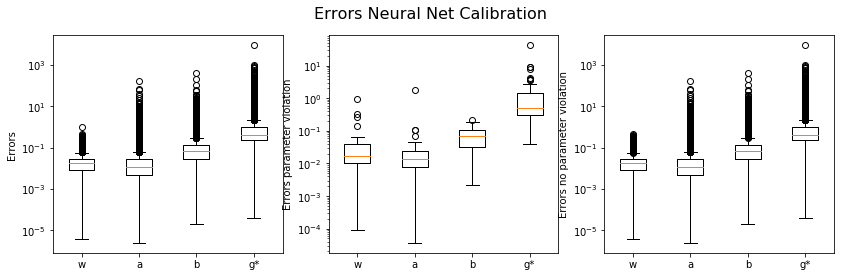

violation error mean in %: [  5.65450035   5.80065936   7.19787927 234.00511325]
no violation error mean in %: [  2.41377306  14.716006    34.88775379 459.50181417]
violation error median in %: [ 1.69245101  1.41527179  6.8381921  50.25173297]
no violation error median in %: [ 1.69399999  1.09276361  6.61976858 41.34068868]
error mean in %: [  2.43408162  14.66013649  34.71423058 458.08870151]
error median in %: [ 1.69364472  1.09552153  6.62007188 41.37252668]


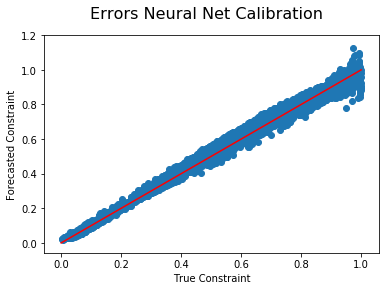

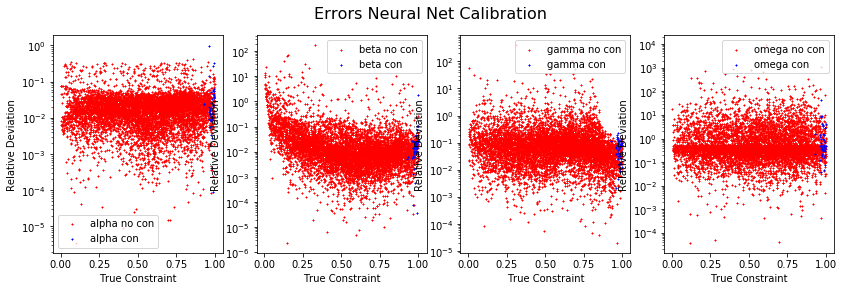

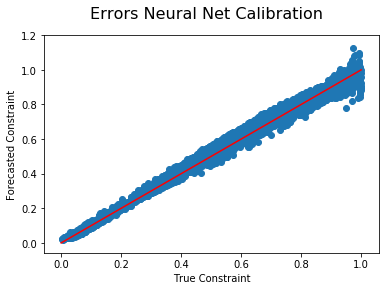

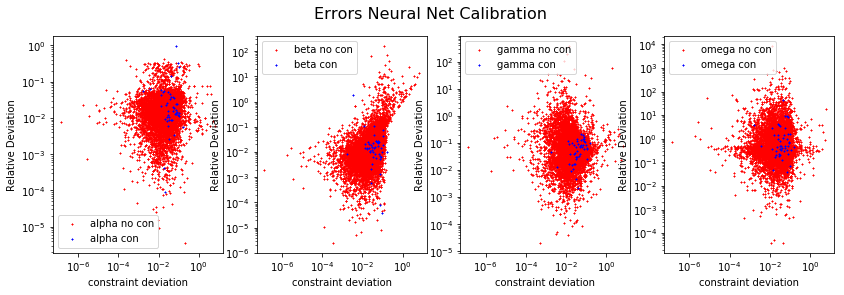

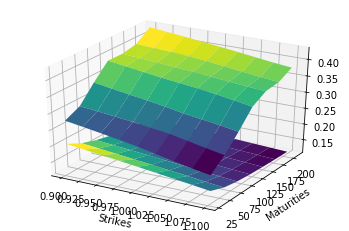

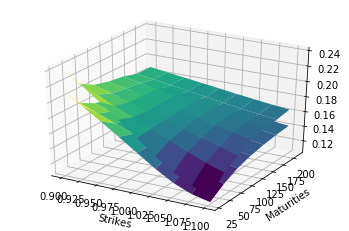

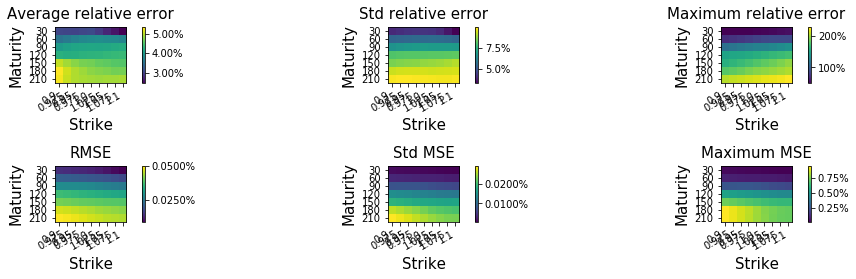

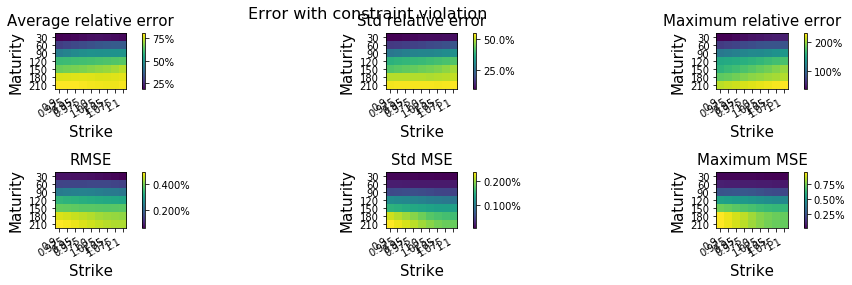

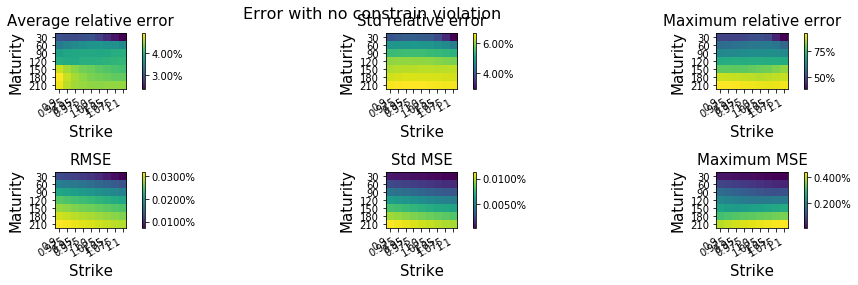

In [7]:
NN2c = Sequential() 
NN2c.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2c.add(Conv2D(12,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Conv2D(24,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(MaxPooling2D(pool_size=(2, 2)))
NN2c.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Flatten())
NN2c.add(Dense(Nparameters,activation = "tanh", kernel_constraint = tf.keras.constraints.NonNeg(),use_bias=True))
NN2c.summary()

#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])

#setting
#NN2c.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#history = NN2c.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
#    epochs=300, verbose = True, shuffle=1)
#NN2.save_weights("calibrationweights_elutanh_noh0.h5")
NN2c.load_weights("calibrationweights_elutanh_noh0.h5")


# ### 5.1 Results

# In[10]:



from add_func_noh0 import calibration_plotter
prediction_calibration = NN2c.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])

#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)

# In[Testing the performace of the AutoEncoder/Decoder Combination]
# We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.


forecast = autoencoder(NN1,NN2c)(y_test_trafo2)
#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)

